## Cats and dogs classification using pretrained ResNet50 CNN
- Dataset information: **OXFORD-IIIT PET Dataset**
- Model in this notebook is trained on **37 category pet dataset(cats and dogs) with roughly 200 images for each class**. The images have a large variations in scale, pose and lighting.

## Necessary imports 

In [1]:
import numpy as np
import pandas as pd
import random
import os
import cv2

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Input, Flatten
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical

## Data preparation

In [2]:
# Read the labels into a pandas dataframe
path_labels = 'pet_labels\list.txt'     
path_images = 'pet_images'   

df_labels = pd.read_csv(path_labels, skiprows = 6, header = None, sep = ' ')
df_labels.columns = ['Image', 'Class_ID', 'Species', 'Breed_ID']
df_labels.head()

,Image,Class_ID,Species,Breed_ID
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1


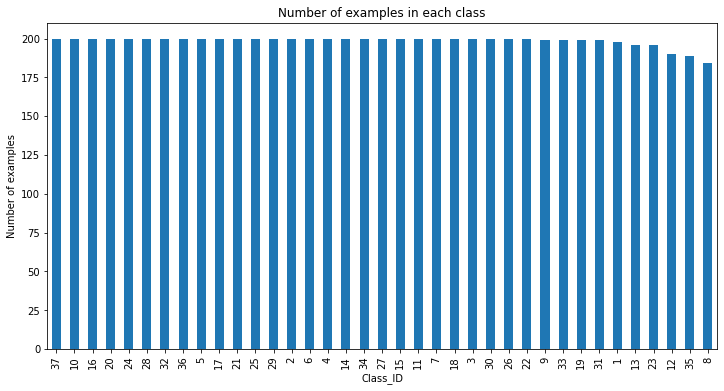

In [3]:
# Check the number of examples in each class
df_labels.Class_ID.value_counts().plot(kind = 'bar', title = 'Number of examples in each class', figsize = (12, 6),
                                      xlabel = 'Class_ID', ylabel = 'Number of examples');

- Each class has almost equal number of examples.

In [4]:
# Check the shape of the labels dataframe
df_labels.shape

(7349, 4)

In [5]:
# Check the number of images
len(os.listdir(path_images))

7390

- **Number of images and labels are not equal**. Proper mapping of images to labels is required. 

#### Read and reshape all images to size (300, 300)
- Store images along with their name in a dictionary for mapping them with their labels.

In [6]:
size = (300, 300)   # target size of images

img_no_labels = {}   # store images without labels
images = {}          # store images with labels 

for img in os.listdir(path_images):
    img_name = img.split('.')[0]   # extract name of the image
    img = cv2.imread(os.path.join(path_images, img))   
    
    # OpenCV didn't read some images
    if img is not None:
        # Check the image name in labels dataframe
        if img_name in df_labels.Image.values:
            images[img_name] = cv2.resize(img, size)
        else:
            img_no_labels[img_name] = cv2.resize(img, size)
    else:
        print(img_name)   # images not read by imread function

Abyssinian_34
Egyptian_Mau_139
Egyptian_Mau_145
Egyptian_Mau_167
Egyptian_Mau_177
Egyptian_Mau_191


In [7]:
# Check the number of images in each dictionary
print('Number of images with labels: ', len(images))
print('Number of images without labels: ', len(img_no_labels))

Number of images with labels:  7349
Number of images without labels:  35


#### Create new dataframe using keys of the images dictionary

In [8]:
keys_df = pd.Series(list(images.keys())).to_frame()
keys_df.columns = ['Image']
keys_df.head()

,Image
0,Abyssinian_1
1,Abyssinian_10
2,Abyssinian_100
3,Abyssinian_101
4,Abyssinian_102


#### Merge the labels dataframe with the keys dataframe on Image column

In [9]:
df = pd.merge(keys_df, df_labels, on = 'Image', how = 'inner')
df.head()

,Image,Class_ID,Species,Breed_ID
0,Abyssinian_1,1,1,1
1,Abyssinian_10,1,1,1
2,Abyssinian_100,1,1,1
3,Abyssinian_101,1,1,1
4,Abyssinian_102,1,1,1


In [10]:
# Check the shape of the resulting dataframe
df.shape

(7349, 4)

- Mapping of images with their correct labels is completed. 

In [11]:
# load the images into numpy array
img = np.array(list(images.values())) 
# free the dictionary memory
images.clear()

## Display few random images 

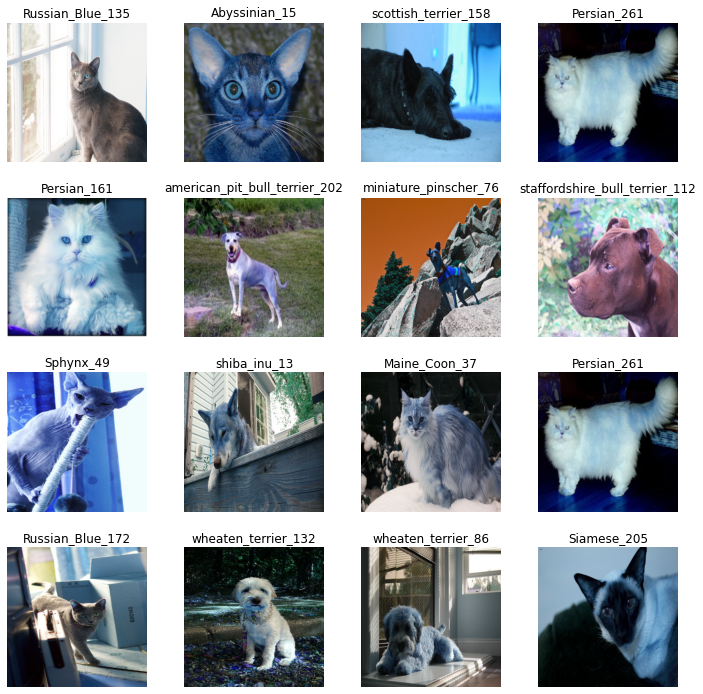

In [12]:
fig = plt.figure(figsize = (10, 10))
columns = 4; rows = 4

# sample random indices of images
index = np.random.randint(0, len(img), size = 16)

for i in range(0, columns * rows):
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(img[index[i]])
    plt.title(str(df.Image.iloc[index[i]]))
    plt.axis('off')
plt.tight_layout(w_pad = 0.1, h_pad = 0.1)
plt.show()

## Partition data into train and validation sets

In [13]:
train_x, val_x, train_y, val_y = train_test_split(img, df.Class_ID.values, test_size = 0.2, random_state = 42, 
                                                  stratify = df.Class_ID.values)

print('Train_x shape: ', train_x.shape)
print('Test_x shape: ', val_x.shape)

Train_x shape:  (5879, 300, 300, 3)
Test_x shape:  (1470, 300, 300, 3)


#### Adjust the labels for training

In [14]:
# labels range from (1 - 37). Make them from 0 - 36
train_y = train_y - 1
val_y = val_y - 1

## CNN Model 

#### Load pretrained ResNet50 model

In [15]:
# load the base pre-trained model
base_model = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (300, 300, 3)))

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# flatten the outputs 
x = Flatten()(x)

# add a fully-connected layer
x = Dense(200, activation = 'relu')(x)
x = Dropout(0.5)(x)

# Output layer with 37 classes
predictions = Dense(37, activation = 'softmax')(x)

# Final model
model = Model(inputs = base_model.input, outputs = predictions)

# freeze all convolutional layers
for layer in base_model.layers:
    layer.trainable = False

In [16]:
# print the model summary
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [17]:
# One hot encoding of training and validation labels
train_y = to_categorical(train_y)
val_y = to_categorical(val_y)

# compile the model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# check the shape of one hot encoded labels
train_y.shape

(5879, 37)

In [18]:
# Make last two blocks of the base_model trainable:

for layer in base_model.layers[:155]:
    layer.trainable = False
    
for layer in base_model.layers[155:]:
    layer.trainable = True

print('Last two block of the base_model are now trainable')

Last two block of the base_model are now trainable


In [ ]:
# Training data augmentation using image data generator
train_Aug = ImageDataGenerator(horizontal_flip = True)

# validation data augmentation
val_Aug = ImageDataGenerator()

# define the ImageNet mean subtraction (in RGB order) 
mean = np.array([123.68, 116.779, 103.939], dtype = "float32")
train_Aug.mean = mean
val_Aug.mean = mean

# fit the model
history = model.fit(x = train_Aug.flow(train_x, train_y, batch_size = 64), validation_data = val_Aug.flow(val_x, val_y), 
          steps_per_epoch = len(train_x) // 64, epochs = 10)

Epoch 1/10
91/91 [==============================] - 103s 1s/step - loss: 2.0200 - accuracy: 0.4335 - val_loss: 0.6806 - val_accuracy: 0.8238
Epoch 2/10
91/91 [==============================] - 107s 1s/step - loss: 0.7983 - accuracy: 0.7561 - val_loss: 0.4251 - val_accuracy: 0.8769
Epoch 3/10
91/91 [==============================] - 111s 1s/step - loss: 0.5556 - accuracy: 0.8294 - val_loss: 0.3555 - val_accuracy: 0.8871
Epoch 4/10
91/91 [==============================] - 80s 876ms/step - loss: 0.4438 - accuracy: 0.8564 - val_loss: 0.3301 - val_accuracy: 0.8932
Epoch 5/10
91/91 [==============================] - 89s 977ms/step - loss: 0.3919 - accuracy: 0.8777 - val_loss: 0.3099 - val_accuracy: 0.8939
Epoch 6/10
91/91 [==============================] - 141s 2s/step - loss: 0.3213 - accuracy: 0.8953 - val_loss: 0.2978 - val_accuracy: 0.9041
Epoch 7/10
91/91 [==============================] - 137s 2s/step - loss: 0.2955 - accuracy: 0.9077 - val_loss: 0.2878 - val_accuracy: 0.9034
Epoch 8/1

## Plot the loss and accuracy results